In [4]:
#given returns, and sum to one
#用一个函数记录收益 方差 夏普比
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.pyplot as plt

In [7]:
import requests
import urllib3
from pandas_datareader import data as pdr
import numpy as np

import yahoo_fin as yf
from yahoo_fin.stock_info import get_data
#ops.get_calls("BTC-USD")
ten_yield = get_data('^TNX')
eth = get_data('ETH-USD')
btc = get_data('BTC-USD')

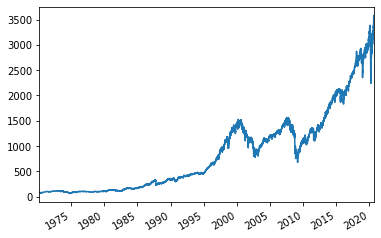

In [73]:
get_data('^GSPC').close.plot()


In [19]:
assets = [ten_yield, eth, btc]
ten_yield

,open,high,low,close,adjclose,volume,ticker
1970-03-25,6.960,6.960,6.960,6.960,6.960,0.0,^TNX
1970-03-26,6.980,6.980,6.980,6.980,6.980,0.0,^TNX
1970-03-27,NaN,NaN,NaN,NaN,NaN,NaN,^TNX
1970-03-29,NaN,NaN,NaN,NaN,NaN,NaN,^TNX
1970-03-30,7.050,7.050,7.050,7.050,7.050,0.0,^TNX
...,...,...,...,...,...,...,...
2020-09-23,0.679,0.692,0.671,0.676,0.676,0.0,^TNX
2020-09-24,0.668,0.674,0.661,0.666,0.666,0.0,^TNX
2020-09-25,0.659,0.664,0.651,0.659,0.659,0.0,^TNX
2020-09-27,NaN,NaN,NaN,NaN,NaN,NaN,^TNX


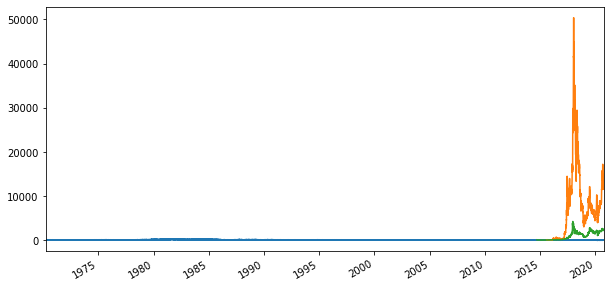

In [39]:
close = [assets[i]['close'] for i in range(len(assets))]
for i in range(len(close)):
    (close[i]/close[i][0] * 100).plot(figsize = (10
                                                 , 5))



[array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13a50fdd0>]],
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13a512510>]],
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13a7edc90>]],
       dtype=object)]

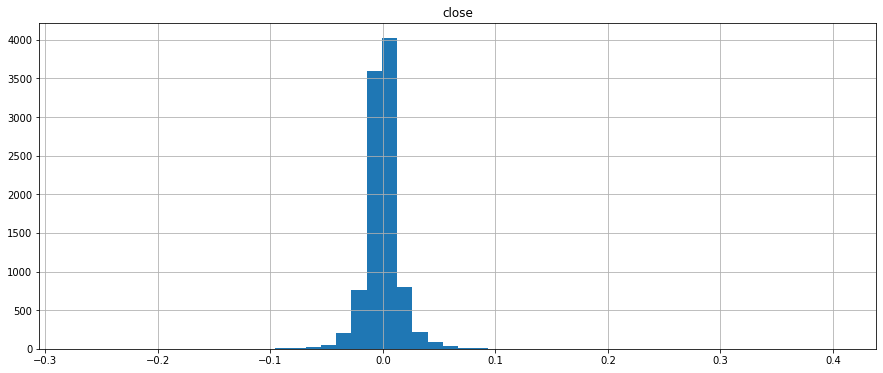

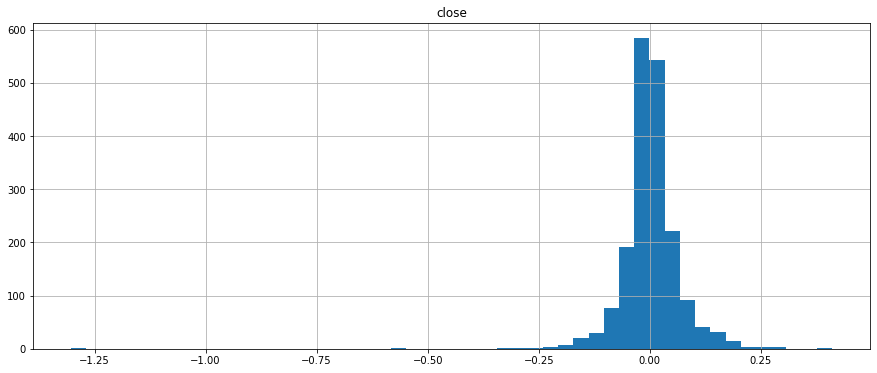

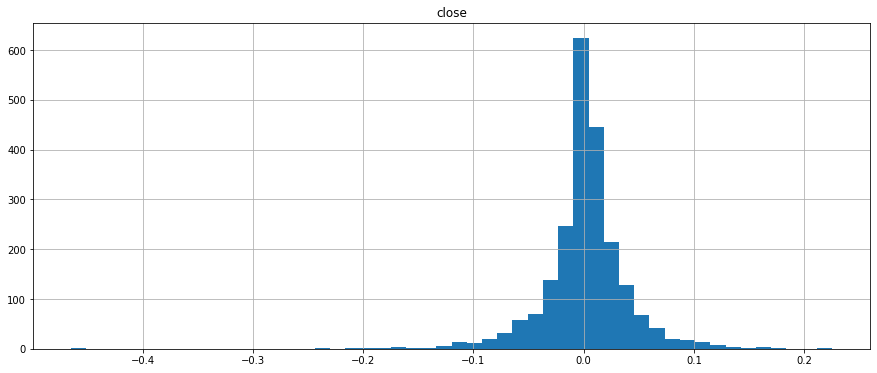

In [52]:
returns = [pd.DataFrame(np.log(clo/clo.shift(1))) for clo in close]
k = lambda returnss: returnss.hist(bins = 50, figsize = (15, 6))
list(map(k, returns))

In [77]:
from functools import reduce
df_merged = reduce(lambda  left,right: pd.merge(left,right, left_index = True, right_index = True,
                                            how='outer'), returns)
df = df_merged.copy()
df = df.dropna()
df.cov()

,close_x,close_y,close
close_x,0.001163,-0.000037,-0.000019
close_y,-0.000037,0.005788,0.001505
close,-0.000019,0.001505,0.001749


In [130]:
rs, vs = [], []
for i in range(1000):
    weights = np.random.random(len(assets))
    weights /= np.sum(weights)
    r = np.sum(weights * 365 * df.mean())
    v = np.sqrt(np.dot(weights.T, np.dot(df.cov() * 365, weights)))
    rs.append(r)
    vs.append(v)

In [96]:
def stats(weights):
    weights = np.array(weights)
    returns = np.sum(df.mean() * weights.T) * 252
    variance = np.sqrt(np.dot(weights.T, np.dot(df.cov() * 252, weights)))
    return returns, variance, returns/variance

In [97]:
#max sharpe large
import scipy.optimize as sco
sharpes = lambda x: -stats(weights)[2]
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(len(assets)))

opts = sco.minimize(sharpes, [1/len(assets)] * 3, method = 'SLSQP', bounds = bnds, constraints = cons)

In [98]:
opts['x']

array([0.33333333, 0.33333333, 0.33333333])

In [99]:
stats(opts['x'])

(0.48020027042099533, 0.569855594658076, 0.842670099096113)

In [100]:
##min variance
def min_variance(weights):
    return stats(weights)[1]

optv = sco.minimize(min_variance, [1/len(assets)] * 3, method = 'SLSQP', bounds = bnds, constraints = cons)
optv

     fun: 0.4160039297228862
     jac: array([0.41617332, 0.41593294, 0.41574079])
 message: 'Optimization terminated successfully.'
    nfev: 25
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.59767188, 0.0241098 , 0.37821832])

In [101]:
stats(optv['x'])

(0.1837260220371656, 0.4160039297228862, 0.44164491945917794)

In [116]:
target = np.linspace(0, 0.5, 50)
weights, variances = [], []
for tar in target:
    cons = ({'type': 'eq', 'fun': lambda x: stats(x)[0] - tar }, {'type': 'eq', 'fun': lambda x: np.sum(x) -1})
    res = sco.minimize(min_variance, [1/len(assets)] * len(assets), method = 'SLSQP', bounds = bnds, constraints = cons)
    weights.append(res['x'])
    variances.append(res['fun'])

In [121]:
target
variances
weights

[array([8.29257189e-01, 5.55111512e-17, 1.70742811e-01]),
 array([0.81585327, 0.        , 0.18414673]),
 array([0.80244934, 0.        , 0.19755066]),
 array([0.78904542, 0.        , 0.21095458]),
 array([7.75641499e-01, 5.55111512e-17, 2.24358501e-01]),
 array([0.76223758, 0.        , 0.23776242]),
 array([0.74883365, 0.        , 0.25116635]),
 array([7.35429731e-01, 5.55111512e-17, 2.64570269e-01]),
 array([0.72202581, 0.        , 0.27797419]),
 array([7.08621886e-01, 1.11022302e-16, 2.91378114e-01]),
 array([6.95217963e-01, 1.11022302e-16, 3.04782037e-01]),
 array([0.68181404, 0.        , 0.31818596]),
 array([0.66910551, 0.00171879, 0.32917571]),
 array([0.65729036, 0.00564578, 0.33706386]),
 array([0.64536964, 0.00931182, 0.34531854]),
 array([0.63344907, 0.01297821, 0.35357272]),
 array([0.62152867, 0.01664504, 0.36182629]),
 array([0.60960845, 0.02031233, 0.37007922]),
 array([0.5976884 , 0.02398003, 0.37833157]),
 array([0.58576847, 0.027648  , 0.38658353]),
 array([0.57384855, 

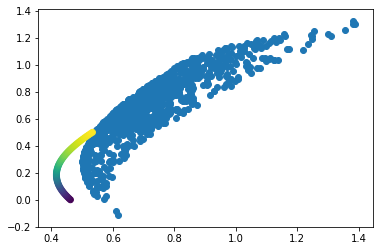

In [139]:
plt.scatter(vs, rs)
plt.scatter(variances, target, c = target/variances, marker = 'o'
        )